In [117]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from typing import List

In [118]:
# Leitura dos dados e tratamento
df_inmet = pd.read_csv(
    filepath_or_buffer="../dados/inmet/dados_A401_H_2001-01-01_2022-08-23.csv", sep=";", header=9
)
df_nasa = pd.read_csv(
    filepath_or_buffer="../dados/nasa/A401.csv", sep=","
)



In [119]:
# Tira colunas que não serão utilizadas
df_inmet = df_inmet[["Hora Medicao", "Data Medicao", "RADIACAO GLOBAL(Kj/m²)"]]
df_nasa.drop(["QV2M", df_nasa.columns[0], df_nasa.columns[-1]], axis=1, inplace=True)

In [120]:
# Converter a data e hora do inmet no formato datetime.
def converter_dados_inmet_em_datetime(data_series: pd.Series, hora_series: pd.Series):

    hora_series = (hora_series/100).map(int)

    data_horario_series: List[datetime] = []
    
    assert len(hora_series) == len(data_series)
    for i in range(len(hora_series)):
        data_str = data_series.iloc[i]
        data = datetime(year=int(data_str[0:4]), month=int(data_str[5:7]),  day=int(data_str[8:10]), hour=hora_series[i], minute=0, second=0)
        data_horario_series.append(data)
    return pd.Series(data_horario_series)

def converter_dados_nasa_em_datetime(year_s: pd.Series, mes_s: pd.Series, dia_s: pd.Series, hora_s: pd.Series):

    data_horario_series: List[datetime] = []

    for i in range(len(year_s)):
        data = datetime(year=int(year_s.iloc[i]), month=int(mes_s.iloc[i]),  day=int(dia_s.iloc[i]), hour=hora_s.iloc[i], minute=0, second=0)
        data_horario_series.append(data)
    return pd.Series(data_horario_series)



In [121]:
# Cria uma coluna com data + horario no INMET
df_inmet["Data_Horario"] = converter_dados_inmet_em_datetime(df_inmet["Data Medicao"].copy(), df_inmet["Hora Medicao"].copy())
# Cria uma coluna com data + horario na NASA
df_nasa["Data_Horario"] = converter_dados_nasa_em_datetime(df_nasa["YEAR"].copy(), df_nasa["MO"].copy(), df_nasa["DY"].copy(), df_nasa["HR"].copy())

# Exclusao das Colunas Temporais separadas
df_inmet.drop(labels=["Data Medicao", "Hora Medicao"], axis=1, inplace=True)
df_nasa.drop(labels=["YEAR", "MO", "DY", "HR"], axis=1, inplace=True)

# Index no Data_Horario
df_inmet.set_index(keys="Data_Horario", inplace=True)
df_nasa.set_index(keys="Data_Horario", inplace=True)

In [122]:
# Junta os Dataframes
df_inmet_nasa = df_nasa.join(other=df_inmet,how='left')
df_inmet_nasa.reset_index(inplace=True)

In [123]:
# Visualizacao
# Titulos das features
titulos = [
    "Temperatura (°C)",
    "Temperatura de Orvalho(°C)",
    "Temperatura de Bulbo Úmido(°C)",
    "Umidade Relativa(%)",
    "Precipitação Média(mm/hora)",
    "Pressão na Superfície",
    "Direção do vento a 10m(°)",
    "Velocidade do vento a 10m(m/s)",
    "Direção do vento a 50m(°)",
    "Velocidade do vento a 50m(m/s)",
    "Radiação Global(Kj/m²)",
]

keys_features = [
    "T2M",
    "T2MDEW",
    "T2MWET",
    "RH2M",
    "PRECTOTCORR",
    "PSC",
    "WD10M",
    "WS10M",
    "WD50M",
    "WS50M",
    "RADIACAO GLOBAL(Kj/m²)"
]

cores = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "black",
    "turquoise",
    "palegreen",
]

nome_coluna_data = "Data_Horario"

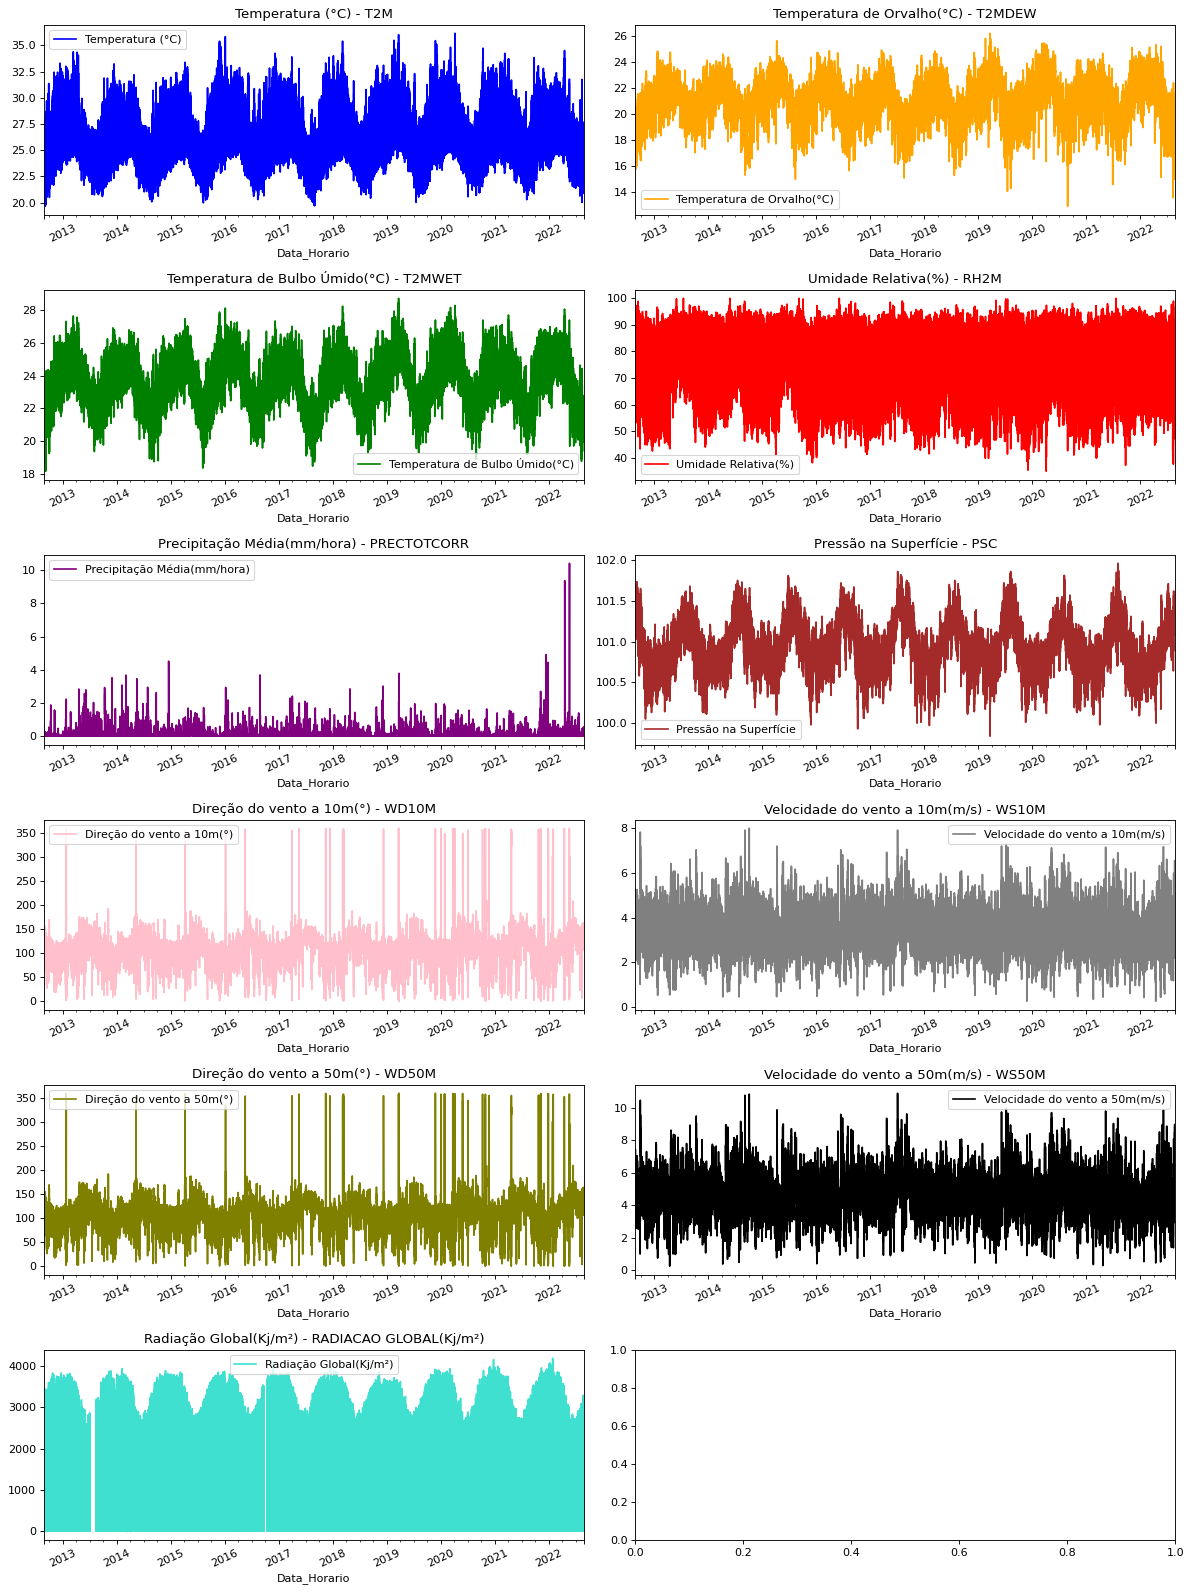

In [124]:
# Visualização dos Dados Completos
def visualizacao(data):
    time_data = data[nome_coluna_data]
    fig, axes = plt.subplots(
        nrows=6, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(keys_features)):
        key = keys_features[i]
        c = cores[i % (len(cores))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titulos[i], key),
            rot=25,
        )
        ax.legend([titulos[i]])
    plt.tight_layout()

visualizacao(data=df_inmet_nasa)

In [125]:
# Pre-tratamento dos dados

def replace_negative(x):
    if x < 0:
        return 0.0
    else:
        return x

# Substituição de todos os valores negativos de Radiação Global por valores positivos
df_inmet_nasa['RADIACAO GLOBAL(Kj/m²)'] = df_inmet_nasa['RADIACAO GLOBAL(Kj/m²)'].apply(replace_negative).reset_index(drop=True)

# Tratamento de valores nulos
# Tentativa a) Aprendizado com a média para o horário e mês, tirado de todos os anos
df_inmet_nasa = df_inmet_nasa.set_index(keys="Data_Horario")
df_inmet_nasa_colunas_tratadas = df_inmet_nasa[keys_features]
df_inmet_nasa_group = df_inmet_nasa_colunas_tratadas.groupby([df_inmet_nasa_colunas_tratadas.index.month, df_inmet_nasa_colunas_tratadas.index.day, df_inmet_nasa_colunas_tratadas.index.hour]).transform('mean')
df_inmet_nasa = df_inmet_nasa.fillna(df_inmet_nasa_group)
df_inmet_nasa = df_inmet_nasa.reset_index()


# Conversão de Radiação Global em kJ/m² para Irradiância em W/m² (a média)
df_inmet_nasa['IRRADIÂNCIA'] = df_inmet_nasa['RADIACAO GLOBAL(Kj/m²)']*(1000/(60*60))

df_inmet_nasa.drop(labels=['RADIACAO GLOBAL(Kj/m²)'], axis=1, inplace=True)

titulos = [
    "Temperatura (°C)",
    "Temperatura de Orvalho(°C)",
    "Temperatura de Bulbo Úmido(°C)",
    "Umidade Relativa(%)",
    "Precipitação Média(mm/hora)",
    "Pressão na Superfície",
    "Direção do vento a 10m(°)",
    "Velocidade do vento a 10m(m/s)",
    "Direção do vento a 50m(°)",
    "Velocidade do vento a 50m(m/s)",
    "Irradiância(W/m²)",
]

keys_features = [
    "T2M",
    "T2MDEW",
    "T2MWET",
    "RH2M",
    "PRECTOTCORR",
    "PSC",
    "WD10M",
    "WS10M",
    "WD50M",
    "WS50M",
    "IRRADIÂNCIA"
]

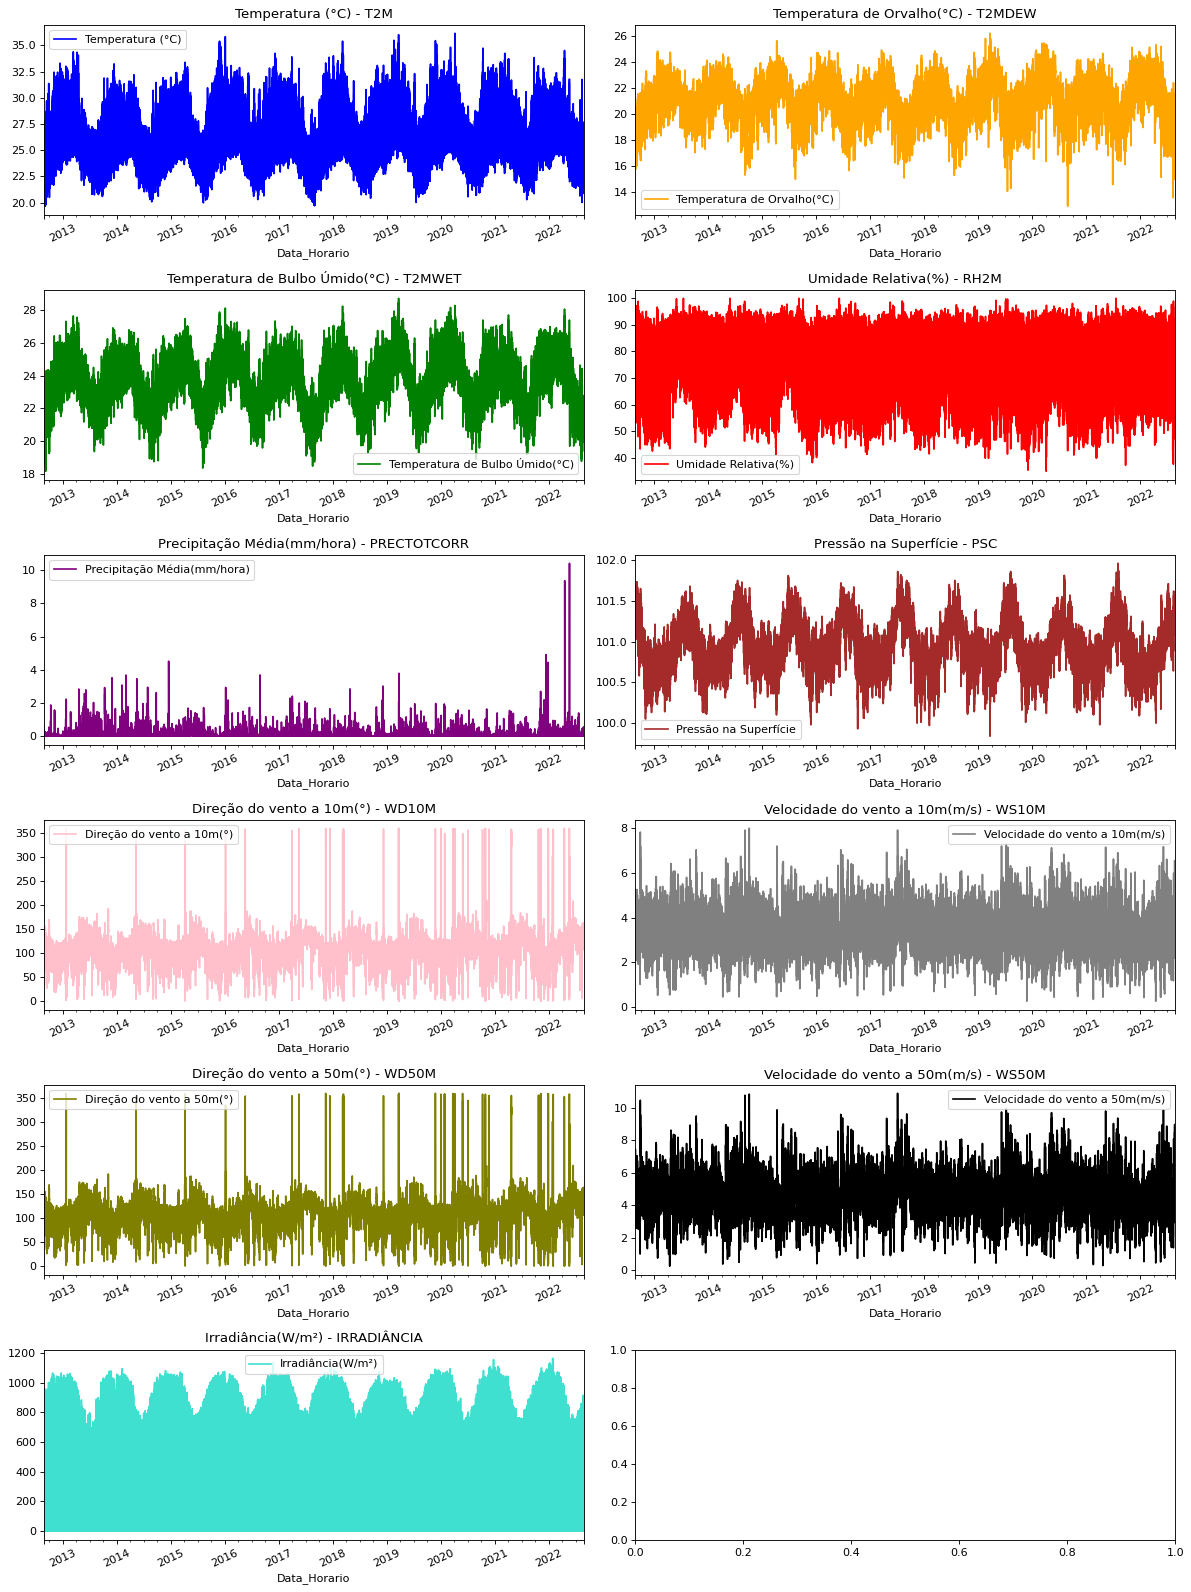

In [126]:
# Visualizacao
visualizacao(data=df_inmet_nasa)

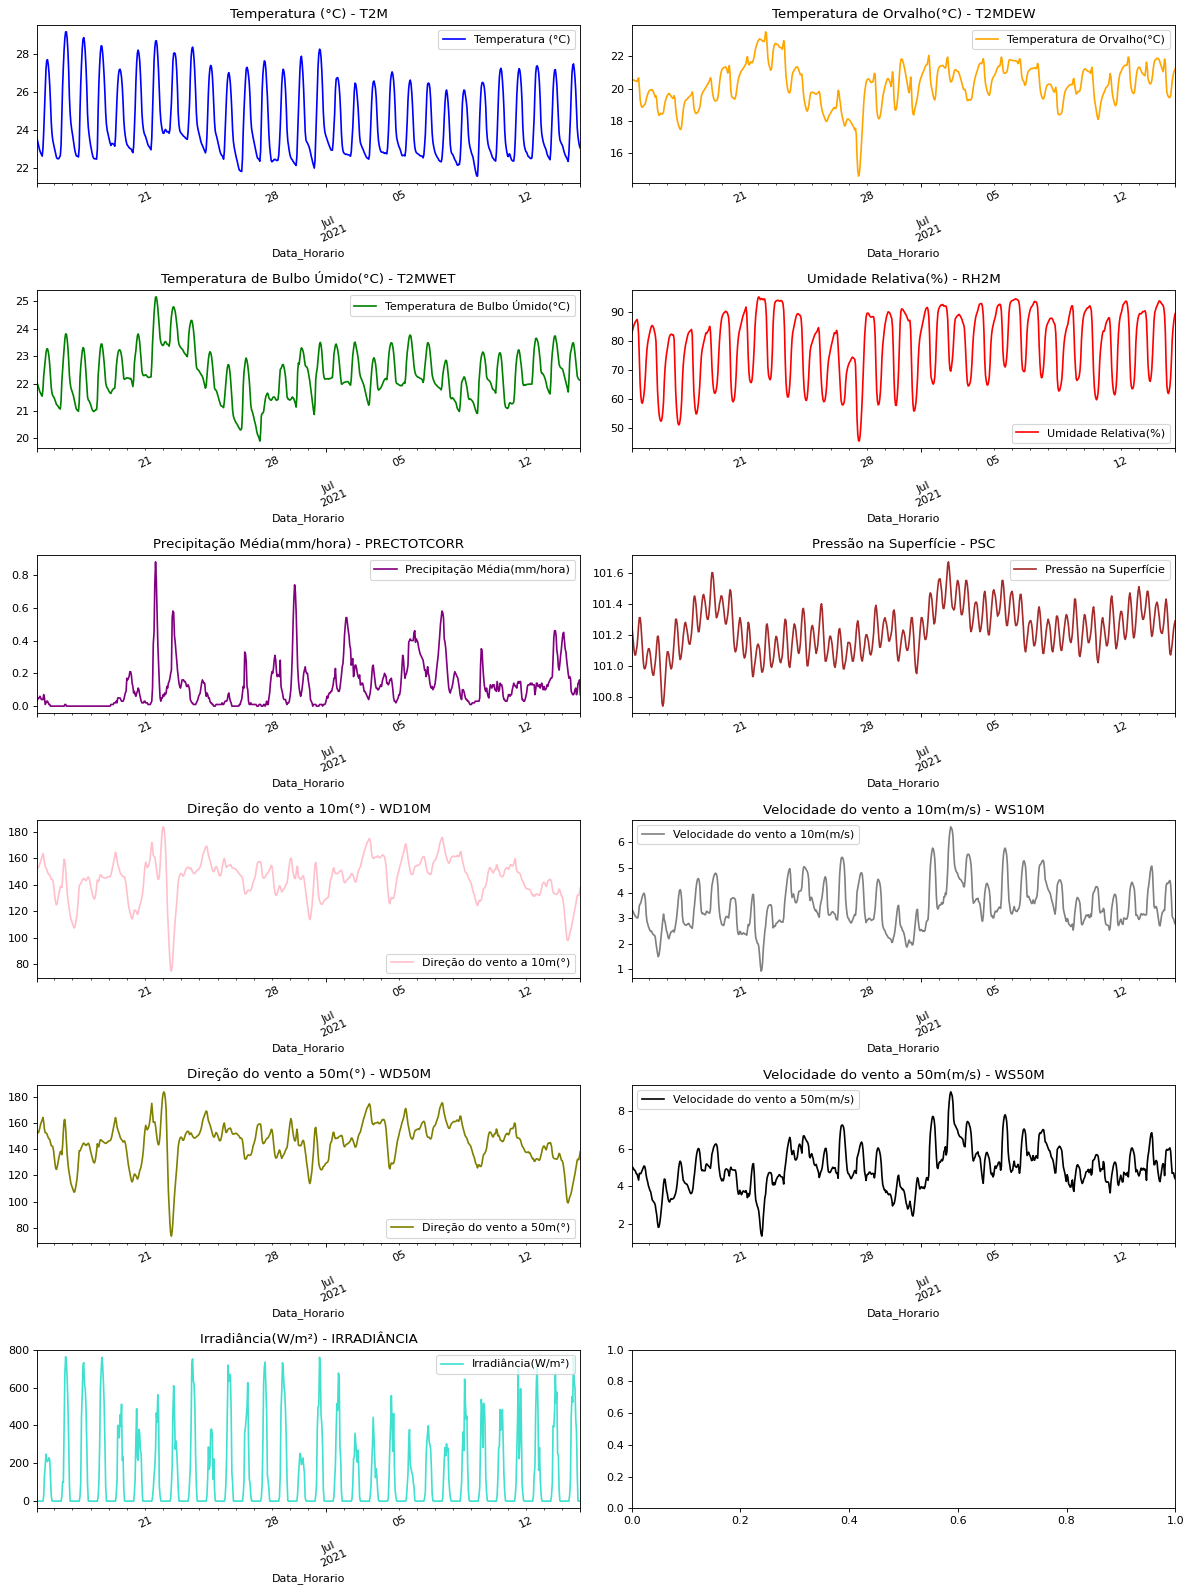

In [127]:
# Plot de um período de 1 mes, para visualização
start_date = '2021-06-15'
end_date   = '2021-07-15'
date_1_mes_mask = (df_inmet_nasa['Data_Horario'] > start_date) & (df_inmet_nasa['Data_Horario'] <= end_date)
df_a_1_mes = df_inmet_nasa.loc[date_1_mes_mask]
visualizacao(data=df_a_1_mes)

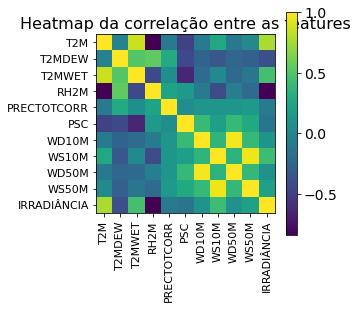

In [128]:
# Heatmap de correlação entre dados (caso_a)
def mostrar_correlacao(dados):
    plt.matshow(dados.corr())
    plt.xticks(range(dados.shape[1]), dados.columns, fontsize=11, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(dados.shape[1]), dados.columns, fontsize=11)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Heatmap da correlação entre as features", fontsize=16)
    plt.show()


mostrar_correlacao(dados=df_inmet_nasa[keys_features])

In [35]:
# Salva os Dados Pré-processados
df_inmet_nasa.to_csv('../dados/pre_processado/salvador.csv')